# XSS Cookie Lab – Evaluación de la API de neutralización

En este notebook analizamos el comportamiento de la API de mitigación de XSS
sobre tres subconjuntos de datos:

- **full**: unión de Kaggle + GitHub
- **github**: solo payloads XSS de GitHub
- **kaggle**: solo payloads XSS de Kaggle

Para cada dataset tenemos tres modos de la API:

- `off`: neutralización desactivada
- `log`: solo registro (no bloqueo)
- `block`: neutralización + bloqueo

A lo largo del notebook medimos:

- Métricas globales de clasificación (TP, FP, FN, TN, *recall*, *precision*, F1).
- Rendimiento por **familia de payload** (`family_main`).
- Rendimiento por **source** (Kaggle vs GitHub dentro del dataset `full`).
- Efecto de **flags estructurales** (`has_script_tag`, `has_event`, `has_js_uri`, `has_iframe`).
- Análisis de **falsos positivos** y **falsos negativos**, incluyendo:
  - Payloads benignos bloqueados (FP).
  - Payloads etiquetados como XSS que la API no bloquea (FN).
- Exploración de **umbrales de decisión** usando el número de patrones detectados
  (`n_matches`, `n_groups`).
- Distribución de **longitudes de payload** según tipo de error (TP, FP, FN, TN).

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", context="talk")

NOTEBOOK_DIR = Path.cwd().resolve()
BASE_DIR = NOTEBOOK_DIR.parent

RESULTS_DIR = BASE_DIR / "notebooks" / "results"

LABEL_COLUMN = "Label"

## Carga de resultados de la API

En esta sección cargamos los resultados de la API para cada combinación
dataset–modo:

- **full / github / kaggle**
- **off / log / block**

Cada CSV contiene, entre otras columnas:

- `Sentence_clean`: payload ya limpiado.
- `Label`: etiqueta de verdad (1 = XSS, 0 = benigno).
- `family_main`: familia principal del payload (event, script, benign, etc.).
- Flags estructurales: `has_script_tag`, `has_event`, `has_js_uri`, `has_iframe`.
- Campos de la API: `api_original`, `api_sanitized`, `api_blocked`,
  `api_category`, `api_mode`, `api_raw_json`.

In [2]:
DATASET_MODE_CSV: Dict[str, Dict[str, Path]] = {
    "full": {
        "off": RESULTS_DIR / "full" / "off" / "xss_full_with_api_results.csv",
        "log": RESULTS_DIR / "full" / "log" / "xss_full_with_api_results.csv",
        "block": RESULTS_DIR / "full" / "block" / "xss_full_with_api_results.csv",
    },
    "github": {
        "off": RESULTS_DIR / "github" / "off" / "xss_github_with_api_results.csv",
        "log": RESULTS_DIR / "github" / "log" / "xss_github_with_api_results.csv",
        "block": RESULTS_DIR / "github" / "block" / "xss_github_with_api_results.csv",
    },
    "kaggle": {
        "off": RESULTS_DIR / "kaggle" / "off" / "xss_kaggle_with_api_results.csv",
        "log": RESULTS_DIR / "kaggle" / "log" / "xss_kaggle_with_api_results.csv",
        "block": RESULTS_DIR / "kaggle" / "block" / "xss_kaggle_with_api_results.csv",
    },
}

dfs: Dict[str, Dict[str, pd.DataFrame]] = {}

for dataset, modes in DATASET_MODE_CSV.items():
    dfs[dataset] = {}
    for mode, path in modes.items():
        if not path.exists():
            raise FileNotFoundError(f"Results not found for dataset={dataset} mode={mode}: {path}")
        df_mode = pd.read_csv(path)
        dfs[dataset][mode] = df_mode
        print(f"[INFO] Loaded dataset={dataset} mode={mode}: shape={df_mode.shape}")

display(dfs["full"]["off"].head())

[INFO] Loaded dataset=full mode=off: shape=(15351, 18)
[INFO] Loaded dataset=full mode=log: shape=(15351, 18)
[INFO] Loaded dataset=full mode=block: shape=(15351, 18)
[INFO] Loaded dataset=github mode=off: shape=(4516, 18)


[INFO] Loaded dataset=github mode=log: shape=(4516, 18)
[INFO] Loaded dataset=github mode=block: shape=(4516, 18)
[INFO] Loaded dataset=kaggle mode=off: shape=(10835, 18)
[INFO] Loaded dataset=kaggle mode=log: shape=(10835, 18)
[INFO] Loaded dataset=kaggle mode=block: shape=(10835, 18)


,Sentence_clean,Label,families_str,len_after_clean,source,family_main,has_script_tag,has_event,has_js_uri,has_iframe,api_original,api_sanitized,api_blocked,api_category,api_mode,api_error,api_error_message,api_raw_json
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0,image_tag,557,kaggle,benign,False,False,False,False,"<li><a href=""/wiki/File:Socrates.png"" class=""i...","<li><a href=""/wiki/File:Socrates.png"" class=""i...",False,benign,off,NaN,NaN,"{""original"": ""<li><a href=\""/wiki/File:Socrate..."
1,"<tt onmouseover=""alert(1)"">test</tt>",1,event_handler,36,kaggle,event,False,True,False,False,"<tt onmouseover=""alert(1)"">test</tt>","<tt onmouseover=""alert(1)"">test</tt>",False,event,off,NaN,NaN,"{""original"": ""<tt onmouseover=\""alert(1)\"">tes..."
2,"</span> <span class=""reference-text"">Steering ...",0,other,230,kaggle,benign,False,False,False,False,"</span> <span class=""reference-text"">Steering ...","</span> <span class=""reference-text"">Steering ...",False,benign,off,NaN,NaN,"{""original"": ""</span> <span class=\""reference-..."
3,"</span> <span class=""reference-text""><cite cla...",0,maybe_polyglot,392,kaggle,benign,False,False,False,False,"</span> <span class=""reference-text""><cite cla...","</span> <span class=""reference-text""><cite cla...",False,benign,off,NaN,NaN,"{""original"": ""</span> <span class=\""reference-..."
4,"</span>. <a href=""/wiki/Digital_object_identif...",0,other,419,kaggle,benign,False,False,False,False,"</span>. <a href=""/wiki/Digital_object_identif...","</span>. <a href=""/wiki/Digital_object_identif...",False,benign,off,NaN,NaN,"{""original"": ""</span>. <a href=\""/wiki/Digital..."


## Métricas globales por dataset y modo

Definimos primero una función para calcular la matriz de confusión y las métricas
derivadas para cada combinación (dataset, modo):

- **TP** (*true positives*): XSS bloqueados correctamente.
- **FN** (*false negatives*): XSS que la API NO bloquea.
- **FP** (*false positives*): tráfico benigno bloqueado erróneamente.
- **TN** (*true negatives*): tráfico benigno no bloqueado.

A partir de estos conteos calculamos:

- `recall_xss` = TP / (TP + FN)
- `miss_rate_xss` = FN / (TP + FN)
- `fpr` = FP / (FP + TN)
- `tnr` = TN / (FP + TN)
- `precision` = TP / (TP + FP)
- `f1` = F1 score binario.

In [3]:
def compute_confusion(df: pd.DataFrame, label_col: str = LABEL_COLUMN) -> dict:
    y_true = df[label_col].astype(int)
    y_pred = df["api_blocked"].astype(bool).astype(int)

    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()

    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    fnr = fn / (tp + fn) if (tp + fn) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (fp + tn) if (fp + tn) else 0.0

    precision = tp / (tp + fp) if (tp + fp) else 0.0
    f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0

    return {
        "tp": tp,
        "fn": fn,
        "fp": fp,
        "tn": tn,
        "recall_xss": tpr,
        "miss_rate_xss": fnr,
        "fpr": fpr,
        "tnr": tnr,
        "precision": precision,
        "f1": f1,
    }

rows = []
for dataset, modes in dfs.items():
    for mode, df_mode in modes.items():
        metrics = compute_confusion(df_mode)
        metrics["dataset"] = dataset
        metrics["mode"] = mode
        rows.append(metrics)

df_metrics_all = (
    pd.DataFrame(rows)
    .set_index(["dataset", "mode"])
    .sort_index()
)

display(df_metrics_all)

tp     fn   fp    tn  recall_xss  miss_rate_xss       fpr  \
dataset mode                                                                  
full    block  11404    299  148  3500    0.974451       0.025549  0.040570   
        log        0  11703    0  3648    0.000000       1.000000  0.000000   
        off        0  11703    0  3648    0.000000       1.000000  0.000000   
github  block   4147    238  105    26    0.945724       0.054276  0.801527   
        log        0   4385    0   131    0.000000       1.000000  0.000000   
        off        0   4385    0   131    0.000000       1.000000  0.000000   
kaggle  block   7257     61   43  3474    0.991664       0.008336  0.012226   
        log        0   7318    0  3517    0.000000       1.000000  0.000000   
        off        0   7318    0  3517    0.000000       1.000000  0.000000   

                    tnr  precision        f1  
dataset mode                                  
full    block  0.959430   0.987188  0.980778  
        log    1.000000   0.000000  0.000000  
        off    1.000000   0.000000  0.000000  
github  block  0.198473   0.975306  0.960287  
        log    1.000000   0.000000  0.000000  
        off    1.000000   0.000000  0.000000  
kaggle  block  0.987774   0.994110  0.992885  
        log    1.000000   0.000000  0.000000  
        off    1.000000   0.000000  0.000000

### Interpretación de las métricas globales

Usando los resultados mostrados en `df_metrics_all`:

- En el dataset **full** y modo **block**:
  - Se obtienen **11 404 TP** y **299 FN** para XSS.
  - El *recall* para XSS es de **0.974451**, es decir, se detecta y bloquea
    aproximadamente el **97.4 %** de los payloads maliciosos.
  - El sistema comete **148 FP** frente a **3500 TN**, lo que implica un
    `fpr` de **0.040570** (alrededor del **4.1 %** de tráfico benigno es
    bloqueado).
  - La precisión es **0.987188** y el F1 es **0.980778**, lo que indica un
    muy buen equilibrio entre *recall* y *precision* para XSS.

- En el dataset **github** y modo **block**:
  - Hay **4147 TP**, **238 FN**, **105 FP** y solo **26 TN** (el conjunto es
    extremadamente desbalanceado hacia XSS).
  - El *recall* es **0.945724** (~**94.6 %**), pero la `fpr` es muy alta
    (**0.801527**), ya que casi todos los ejemplos etiquetados como benignos
    son bloqueados.

- En el dataset **kaggle** y modo **block**:
  - Se observan **7257 TP**, **61 FN**, **43 FP** y **3474 TN**.
  - El *recall* de XSS es **0.991664** (~**99.2 %**), muy alto.
  - La `fpr` es **0.012226** (~**1.2 %**), por lo que casi todo el tráfico
    benigno de Kaggle se deja pasar.
  - La precisión (**0.994110**) y F1 (**0.992885**) son también muy altas.

En los modos `off` y `log`, la API no bloquea nada (`api_blocked = 0`), por lo que
las métricas para XSS son triviales: `recall_xss = 0` y `miss_rate_xss = 1`.

En resumen, el modo **block** consigue detectar la mayoría de los XSS, pero el
trade-off entre *recall* y falsos positivos es muy distinto según el origen
(github vs kaggle).

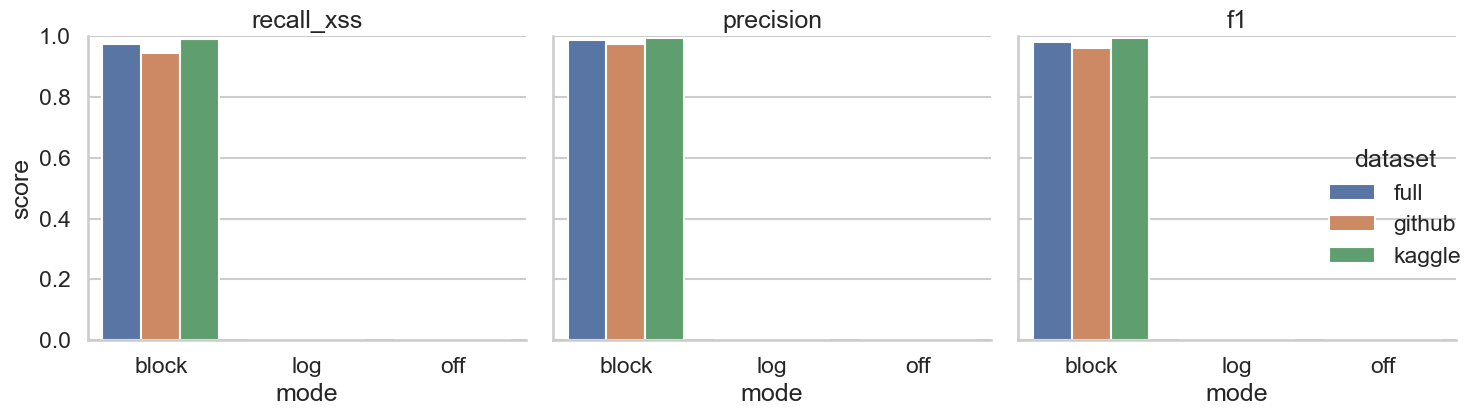

In [4]:
metrics_to_plot = ["recall_xss", "precision", "f1"]

df_plot = (
    df_metrics_all.reset_index()
    .melt(
        id_vars=["dataset", "mode"],
        value_vars=metrics_to_plot,
        var_name="metric",
        value_name="score",
    )
)

g = sns.catplot(
    data=df_plot,
    x="mode",
    y="score",
    hue="dataset",
    col="metric",
    kind="bar",
    height=4.5,
    aspect=1.0,
)
g.set_titles("{col_name}")
g.set_axis_labels("mode", "score")
for ax in g.axes.flatten():
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

El gráfico de barras por métrica (recall, precision, F1) ilustra:

- Cómo el modo **block** concentra todo el rendimiento (en `off` y `log` las
  métricas son nulas porque no hay bloqueo).
- La diferencia entre datasets:
  - **Kaggle** presenta el mejor compromiso: *recall* casi perfecto y muy pocas
    falsas alarmas.
  - **GitHub** logra buen *recall*, pero a costa de muchos falsos positivos,
    lo que degrada la utilidad práctica si el sistema se usa tal cual.

## Rendimiento por familia de payload (`family_main`)

Analizamos ahora el comportamiento por **familia principal de payload** dentro
del modo `block` de cada dataset. Esto permite ver qué tipos de payload son
fáciles de detectar y cuáles generan más errores.

In [5]:
def summarize_by_family(df_mode: pd.DataFrame) -> pd.DataFrame:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    rows = []
    for fam, g in df_eval.groupby("family_main"):
        tp = ((g["y_true"] == 1) & (g["y_pred"] == 1)).sum()
        fn = ((g["y_true"] == 1) & (g["y_pred"] == 0)).sum()
        fp = ((g["y_true"] == 0) & (g["y_pred"] == 1)).sum()
        tn = ((g["y_true"] == 0) & (g["y_pred"] == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0

        rows.append(
            {
                "family_main": fam,
                "n": len(g),
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
            }
        )

    return pd.DataFrame(rows).sort_values("n", ascending=False)

all_family_tables: Dict[str, pd.DataFrame] = {}
all_family_rows = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    df_family = summarize_by_family(df_block)
    df_family["dataset"] = dataset
    all_family_tables[dataset] = df_family
    all_family_rows.append(df_family)

df_family_all = pd.concat(all_family_rows, ignore_index=True)
display(df_family_all)

,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
0,event,7667,7630,29,6,2,0.996214,0.750000,full
1,benign,4030,134,270,128,3498,0.331683,0.035301,full
2,script,3408,3394,0,14,0,1.000000,1.000000,full
3,iframe,210,210,0,0,0,1.000000,0.000000,full
4,js_uri,36,36,0,0,0,1.000000,0.000000,full
5,script,3309,3309,0,0,0,1.000000,0.000000,github
6,event,561,532,29,0,0,0.948307,0.000000,github
7,benign,439,99,209,105,26,0.321429,0.801527,github
8,iframe,207,207,0,0,0,1.000000,0.000000,github
9,event,7106,7098,0,6,2,1.000000,0.750000,kaggle


### Interpretación de la tabla por familia

A partir de `df_family_all`:

- En el dataset **full**:
  - `event` (n = 7667) tiene `recall_xss = 0.996214`, es decir, casi todos los
    payloads basados en eventos son bloqueados.
  - `script` (n = 3408) también tiene `recall_xss = 1.000000`, pero un `fpr`
    de **1.000000**, lo que indica que **todos** los payloads etiquetados como
    benignos en esta familia son bloqueados (cuando existen).
  - `benign` (n = 4030) presenta un `recall_xss = 0.331683` y `fpr = 0.035301`.
    Aquí `recall_xss` se interpreta como proporción de XSS correctamente
    bloqueados dentro de la familia etiquetada como `benign` en el corpus.
    El hecho de que haya XSS dentro de la familia `benign` indica ruido o
    complejidad en la anotación original.

- En **github**:
  - `script` (n = 3309) tiene `recall_xss = 1.000000` y `fpr = 0.000000`,
    lo que sugiere que los XSS basados en `<script>` en GitHub son fáciles
    de detectar sin penalizar tráfico benigno de esa familia.
  - `benign` (n = 439) tiene `recall_xss = 0.321429` y un `fpr = 0.801527`,
    reflejando de nuevo que casi todo lo que está anotado como benigno en esta
    familia termina bloqueado.

- En **kaggle**:
  - `event` (n = 7106) tiene `recall_xss = 1.000000` y `fpr = 0.750000`
    (muy pocos TN en esa familia).
  - `benign` (n = 3591) tiene `recall_xss = 0.364583` y `fpr = 0.006581`,
    aquí la tasa de falsos positivos es mucho más baja que en GitHub.

En conjunto, la API bloquea muy bien las familias claramente maliciosas
(`script`, `event`, `iframe`, `js_uri`), y la parte problemática se concentra
en la familia `benign`, donde hay mezcla de payloads inofensivos con patrones
de XSS “camuflados”.


=== Family summary — dataset=full ===


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
1,event,7667,7630,29,6,2,0.996214,0.750000,full
0,benign,4030,134,270,128,3498,0.331683,0.035301,full
4,script,3408,3394,0,14,0,1.000000,1.000000,full
2,iframe,210,210,0,0,0,1.000000,0.000000,full
3,js_uri,36,36,0,0,0,1.000000,0.000000,full


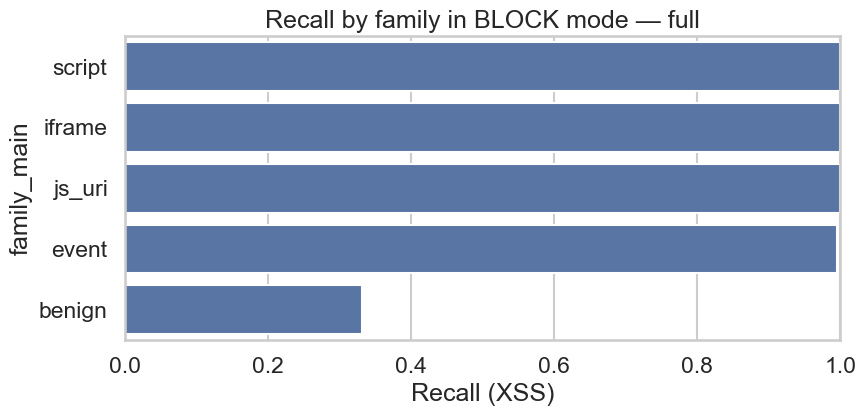


=== Family summary — dataset=github ===


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
3,script,3309,3309,0,0,0,1.000000,0.000000,github
1,event,561,532,29,0,0,0.948307,0.000000,github
0,benign,439,99,209,105,26,0.321429,0.801527,github
2,iframe,207,207,0,0,0,1.000000,0.000000,github


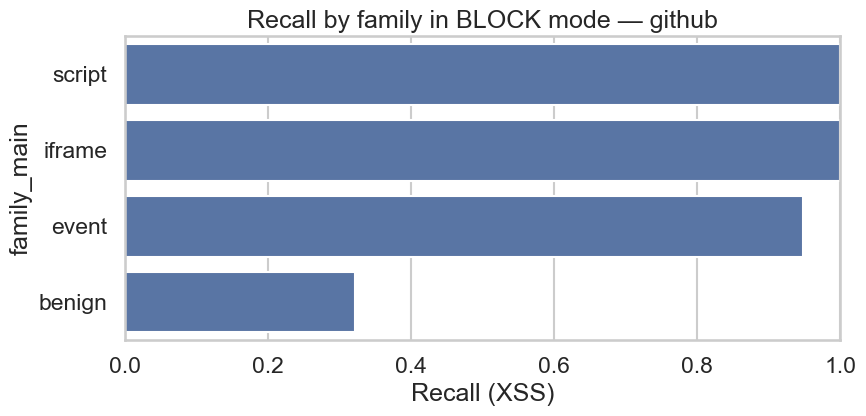


=== Family summary — dataset=kaggle ===


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
1,event,7106,7098,0,6,2,1.000000,0.750000,kaggle
0,benign,3591,35,61,23,3472,0.364583,0.006581,kaggle
4,script,99,85,0,14,0,1.000000,1.000000,kaggle
3,js_uri,36,36,0,0,0,1.000000,0.000000,kaggle
2,iframe,3,3,0,0,0,1.000000,0.000000,kaggle


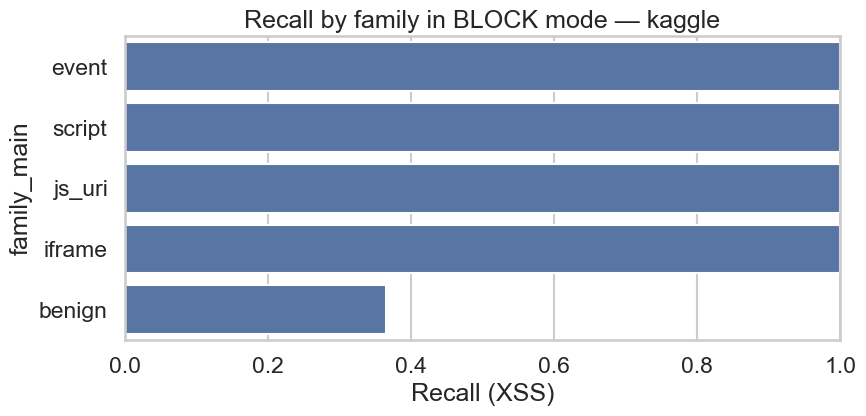

In [6]:
for dataset, table in all_family_tables.items():
    print(f"\n=== Family summary — dataset={dataset} ===")
    display(table)

    plt.figure(figsize=(9, 4.5))
    ordered = table.sort_values("recall_xss", ascending=False)
    sns.barplot(
        data=ordered,
        x="recall_xss",
        y="family_main",
    )
    plt.title(f"Recall by family in BLOCK mode — {dataset}")
    plt.xlim(0, 1)
    plt.xlabel("Recall (XSS)")
    plt.ylabel("family_main")
    plt.tight_layout()
    plt.show()

Los gráficos de *recall* por familia muestran visualmente:

- **Recall cerca de 1.0** para familias claramente maliciosas (`script`,
  `event`, `iframe`, `js_uri`) en todos los datasets.
- **Recall mucho más bajo** en la familia `benign`, lo que refleja la
  dificultad de distinguir entre texto verdaderamente benigno y payloads
  que parecen contenido normal pero contienen patrones de XSS.

## Rendimiento por `source` (Kaggle vs GitHub) en el dataset `full`

En el dataset `full` podemos separar el comportamiento según `source`
(`kaggle` vs `github`) dentro del modo `block`.

In [7]:
def summarize_by_source(df_mode: pd.DataFrame) -> pd.DataFrame:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    rows = []
    for src, g in df_eval.groupby("source"):
        tp = ((g["y_true"] == 1) & (g["y_pred"] == 1)).sum()
        fn = ((g["y_true"] == 1) & (g["y_pred"] == 0)).sum()
        fp = ((g["y_true"] == 0) & (g["y_pred"] == 1)).sum()
        tn = ((g["y_true"] == 0) & (g["y_pred"] == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0

        rows.append(
            {
                "source": src,
                "n": len(g),
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
            }
        )

    return pd.DataFrame(rows).sort_values("n", ascending=False)

df_full_block = dfs["full"]["block"].copy()
df_source_block_full = summarize_by_source(df_full_block)
display(df_source_block_full)

,source,n,tp,fn,fp,tn,recall_xss,fpr
1,kaggle,10835,7257,61,43,3474,0.991664,0.012226
0,github,4516,4147,238,105,26,0.945724,0.801527


### Interpretación por fuente en el dataset `full`

Según `df_source_block_full`:

- Para **Kaggle** (`n = 10835`):
  - `recall_xss = 0.991664` (~**99.2 %** de XSS bloqueados).
  - `fpr = 0.012226` (~**1.2 %** de benignos bloqueados).

- Para **GitHub** (`n = 4516`):
  - `recall_xss = 0.945724` (~**94.6 %**).
  - `fpr = 0.801527` (~**80.2 %** de benignos bloqueados).

Esto confirma que el corpus de GitHub es mucho más “agresivo”: la API termina
bloqueando casi todo lo etiquetado como benigno, mientras que en Kaggle mantiene
una tasa de falsos positivos muy baja.

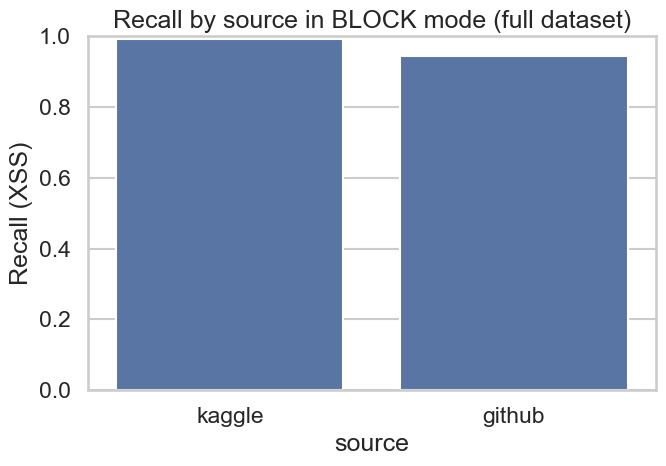

In [8]:
plt.figure(figsize=(7, 5))
sns.barplot(data=df_source_block_full, x="source", y="recall_xss")
plt.title("Recall by source in BLOCK mode (full dataset)")
plt.ylim(0, 1)
plt.xlabel("source")
plt.ylabel("Recall (XSS)")
plt.tight_layout()
plt.show()

## Análisis por flags estructurales

Las columnas booleanas:

- `has_script_tag`
- `has_event`
- `has_js_uri`
- `has_iframe`

indican si el payload contiene ciertos elementos de alto riesgo. Analizamos
cómo cambia el rendimiento dependiendo de si estos flags son `True` o `False`
en cada dataset.

In [9]:
feature_flags = ["has_script_tag", "has_event", "has_js_uri", "has_iframe"]

def summarize_by_flag(df_mode: pd.DataFrame, flag: str) -> pd.DataFrame:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    rows = []
    for val, g in df_eval.groupby(flag):
        tp = ((g["y_true"] == 1) & (g["y_pred"] == 1)).sum()
        fn = ((g["y_true"] == 1) & (g["y_pred"] == 0)).sum()
        fp = ((g["y_true"] == 0) & (g["y_pred"] == 1)).sum()
        tn = ((g["y_true"] == 0) & (g["y_pred"] == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0

        rows.append(
            {
                flag: bool(val),
                "n": len(g),
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
            }
        )

    return pd.DataFrame(rows).sort_values(flag, ascending=False)

flag_tables_all: Dict[str, Dict[str, pd.DataFrame]] = {}

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    flag_tables_all[dataset] = {}
    for flag in feature_flags:
        if flag in df_block.columns:
            table = summarize_by_flag(df_block, flag)
            flag_tables_all[dataset][flag] = table

for dataset, flags_dict in flag_tables_all.items():
    print(f"\n================ Dataset: {dataset} ================")
    for flag, table in flags_dict.items():
        print(f"\n=== {flag} ===")
        display(table)


================ Dataset: full ================

=== has_script_tag ===


,has_script_tag,n,tp,fn,fp,tn,recall_xss,fpr
1,True,3408,3394,0,14,0,1.000000,1.000000
0,False,11943,8010,299,134,3500,0.964015,0.036874



=== has_event ===


,has_event,n,tp,fn,fp,tn,recall_xss,fpr
1,True,7782,7745,29,6,2,0.99627,0.750000
0,False,7569,3659,270,142,3498,0.93128,0.039011



=== has_js_uri ===


,has_js_uri,n,tp,fn,fp,tn,recall_xss,fpr
1,True,43,43,0,0,0,1.000000,0.00000
0,False,15308,11361,299,148,3500,0.974357,0.04057



=== has_iframe ===


,has_iframe,n,tp,fn,fp,tn,recall_xss,fpr
1,True,384,384,0,0,0,1.000000,0.00000
0,False,14967,11020,299,148,3500,0.973584,0.04057



================ Dataset: github ================

=== has_script_tag ===


,has_script_tag,n,tp,fn,fp,tn,recall_xss,fpr
1,True,3309,3309,0,0,0,1.00000,0.000000
0,False,1207,838,238,105,26,0.77881,0.801527



=== has_event ===


,has_event,n,tp,fn,fp,tn,recall_xss,fpr
1,True,620,591,29,0,0,0.953226,0.000000
0,False,3896,3556,209,105,26,0.944489,0.801527



=== has_js_uri ===


,has_js_uri,n,tp,fn,fp,tn,recall_xss,fpr
0,False,4516,4147,238,105,26,0.945724,0.801527



=== has_iframe ===


,has_iframe,n,tp,fn,fp,tn,recall_xss,fpr
1,True,327,327,0,0,0,1.00000,0.000000
0,False,4189,3820,238,105,26,0.94135,0.801527



================ Dataset: kaggle ================

=== has_script_tag ===


,has_script_tag,n,tp,fn,fp,tn,recall_xss,fpr
1,True,99,85,0,14,0,1.000000,1.000000
0,False,10736,7172,61,29,3474,0.991566,0.008279



=== has_event ===


,has_event,n,tp,fn,fp,tn,recall_xss,fpr
1,True,7162,7154,0,6,2,1.000000,0.750000
0,False,3673,103,61,37,3472,0.628049,0.010544



=== has_js_uri ===


,has_js_uri,n,tp,fn,fp,tn,recall_xss,fpr
1,True,43,43,0,0,0,1.000000,0.000000
0,False,10792,7214,61,43,3474,0.991615,0.012226



=== has_iframe ===


,has_iframe,n,tp,fn,fp,tn,recall_xss,fpr
1,True,57,57,0,0,0,1.000000,0.000000
0,False,10778,7200,61,43,3474,0.991599,0.012226


### Interpretación por flags

Algunos patrones destacados de las tablas:

- En **full**:
  - Cuando `has_script_tag = True` (n = 3408), el *recall* es **1.0**:
    todos los XSS con `<script>` son bloqueados.
  - Para `has_script_tag = False`, el *recall* baja a **0.964015** y
    la `fpr` es **0.036874**.
  - `has_js_uri = True` (n = 43) y `has_iframe = True` (n = 384) tienen
    `recall_xss = 1.0`, lo que indica que estos patrones también son
    bloqueados con alta fiabilidad.

- En **github**:
  - Con `has_script_tag = True` (n = 3309), el *recall* es **1.0** y
    la `fpr = 0.0`, lo que significa que no hay benignos en esa combinación.
  - Con `has_script_tag = False` (n = 1207), el *recall* baja a **0.77881**
    y la `fpr` sube a **0.801527**.

- En **kaggle**:
  - `has_event = True` (n = 7162) tiene `recall_xss = 1.0`.
  - `has_event = False` (n = 3673) reduce el *recall* a **0.628049**, pero con
    `fpr = 0.010544`, indicando más dificultad para detectar XSS sin eventos.

En resumen, la API es muy fuerte cuando detecta elementos obvios de XSS
(`<script>`, `javascript:`, `iframe`, eventos), y su rendimiento se degrada
en payloads que no contienen estos indicadores.

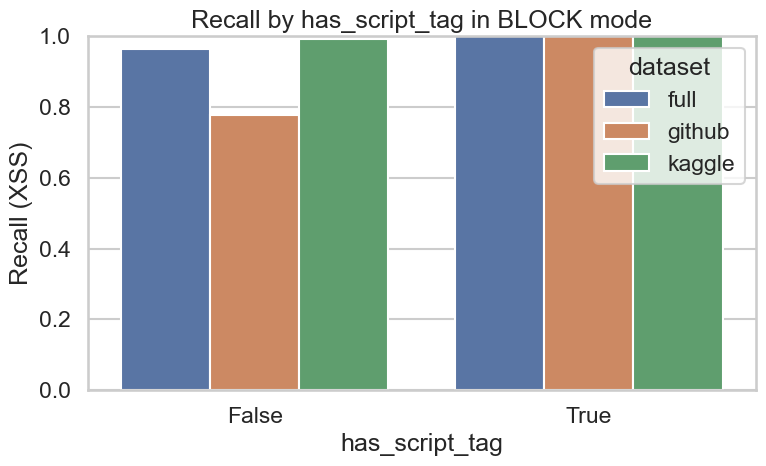

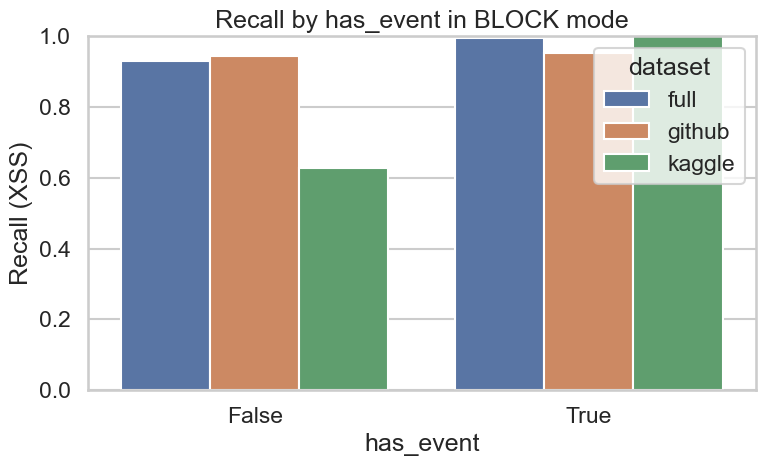

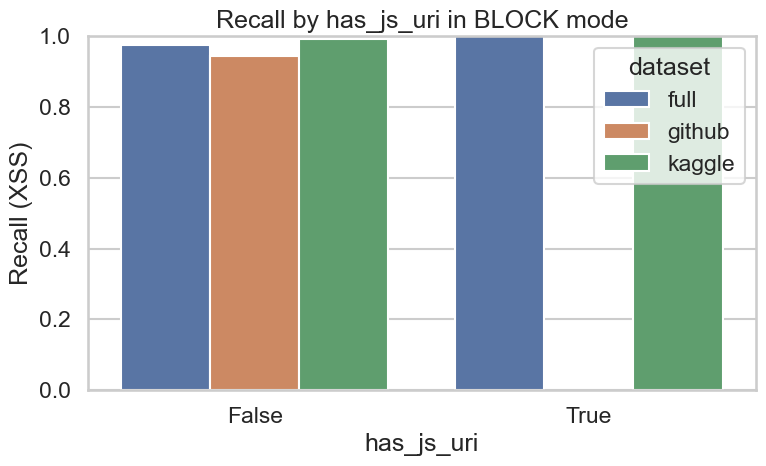

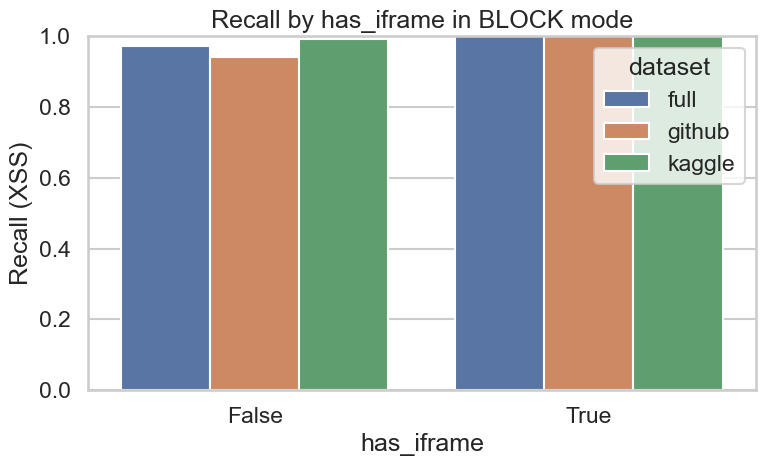

In [10]:
all_flag_rows = []

for dataset, flags_dict in flag_tables_all.items():
    for flag, table in flags_dict.items():
        t = table.copy()
        t["dataset"] = dataset
        t["flag"] = flag
        all_flag_rows.append(t)

df_flags_all = pd.concat(all_flag_rows, ignore_index=True)

for flag in feature_flags:
    df_sub = df_flags_all[df_flags_all["flag"] == flag].copy()
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_sub,
        x=flag,
        y="recall_xss",
        hue="dataset",
    )
    plt.title(f"Recall by {flag} in BLOCK mode")
    plt.ylim(0, 1)
    plt.xlabel(flag)
    plt.ylabel("Recall (XSS)")
    plt.tight_layout()
    plt.show()

Los gráficos por flag confirman visualmente que:

- El *recall* de XSS es muy alto cuando los flags son `True`.
- La diferencia entre datasets se nota sobre todo cuando los flags son `False`,
  donde GitHub sufre más en términos de falsos positivos y falsos negativos.

## Análisis de benignos en GitHub (falsos positivos)

Nos centramos ahora en el dataset de **GitHub**, modo `block`, y analizamos
el subconjunto de payloads etiquetados como benignos (`Label = 0`).

In [11]:
df_github_block = dfs["github"]["block"].copy()

df_github_block["y_true"] = df_github_block[LABEL_COLUMN].astype(int)
df_github_block["y_pred"] = df_github_block["api_blocked"].astype(bool).astype(int)

df_github_block["is_benign"] = df_github_block["y_true"] == 0
df_github_block["is_blocked"] = df_github_block["y_pred"] == 1

df_benign_github = df_github_block[df_github_block["is_benign"]].copy()

print(df_benign_github.shape)
display(df_benign_github.groupby("is_blocked").size().reset_index(name="count"))

(131, 22)


,is_blocked,count
0,False,26
1,True,105


En GitHub, modo `block`, hay **131** payloads etiquetados como benignos.
De ellos:

- **105** están bloqueados (`is_blocked = True`).
- **26** no están bloqueados (`is_blocked = False`).

Esto implica que aproximadamente el **80 %** de los benignos de GitHub son
bloqueados por la API, lo que coincide con la `fpr` alta que vimos en las
métricas globales para este dataset.

In [12]:
flag_cols = ["has_script_tag", "has_event", "has_js_uri", "has_iframe"]

benign_flag_summary = (
    df_benign_github
    .groupby("is_blocked")[flag_cols]
    .mean()
    .reset_index()
)

display(benign_flag_summary)

,is_blocked,has_script_tag,has_event,has_js_uri,has_iframe
0,False,0.0,0.0,0.0,0.0
1,True,0.0,0.0,0.0,0.0


En `benign_flag_summary`, todas las medias de los flags son **0.0**, tanto para
los benignos bloqueados como para los no bloqueados:

- Esto confirma que **los falsos positivos de GitHub no se deben** a la
  presencia de `<script>`, eventos, `javascript:` o `iframe`.
- En cambio, se deben a otras categorías (`api_category`) y patrones más
  sutiles, que veremos a continuación.

Es decir, el sistema bloquea muchos benignos de GitHub aun cuando no contienen
los indicadores estructurales más obvios.

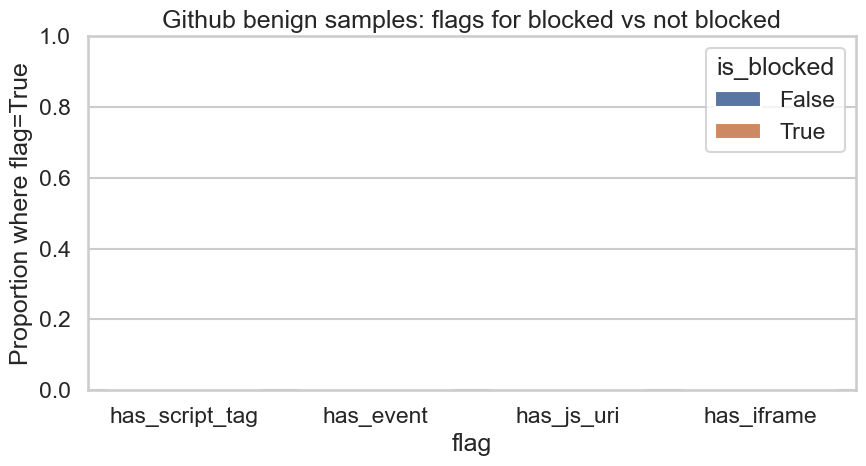

In [13]:
plt.figure(figsize=(9, 5))
sns.barplot(
    data=benign_flag_summary.melt(id_vars="is_blocked", var_name="flag", value_name="ratio_true"),
    x="flag",
    y="ratio_true",
    hue="is_blocked",
)
plt.title("Github benign samples: flags for blocked vs not blocked")
plt.ylim(0, 1)
plt.xlabel("flag")
plt.ylabel("Proportion where flag=True")
plt.tight_layout()
plt.show()

In [14]:
display(
    df_benign_github[df_benign_github["is_blocked"] == True].sample(10, random_state=7)[[
        "Sentence_clean",
        "family_main",
        "families_str",
        "has_script_tag",
        "has_event",
        "has_js_uri",
        "has_iframe",
        "api_category"
    ]]
)

,Sentence_clean,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
4185,<a href=#><line xmlns=urn:schemas-microsoft-co...,benign,other,False,False,False,False,scheme
4275,"<form><a href=""javascript:\\\\u0061lert&#x28;1...",benign,other,False,False,False,False,form_tag
4263,"<table background=""javascript:alert('xss')"">",benign,other,False,False,False,False,scheme
4325,<input id=xss onblur=javascript:eval(string['f...,benign,other,False,False,False,False,form_tag
4082,"<a href=""javas\\\\x00cript:javascript:alert(1)...",benign,other,False,False,False,False,scheme
4214,"<xss style=""xss:expression(javascript:alert(1))"">",benign,other,False,False,False,False,scheme
4044,</html onmouseleave>,benign,other,False,False,False,False,html_like
4342,"<meta http-equiv=""link"" content=""<javascript:a...",benign,other,False,False,False,False,meta_tag
2803,<a href=javascript:alert(1)>aaa<a>,benign,other,False,False,False,False,scheme
4186,"<a style=""behavior:url(#default#anchorclick);""...",benign,other,False,False,False,False,scheme


La muestra aleatoria de benignos bloqueados de GitHub muestra:

- Payloads con categorías como `scheme`, `form_tag`, `html_like`, `meta_tag`,
  `active_tag`, etc.
- Todos ellos con los flags estructurales en `False`.

Esto indica que la API utiliza la categoría `api_category` y patrones
internos (`matches`) para decidir el bloqueo, incluso cuando los flags
más simples son `False`.

## Extracción de `reasons` y `matches` de la API

La columna `api_raw_json` contiene un JSON con detalles de la detección:

- `matches`: lista de patrones encontrados (grupo, patrón, índice de inicio, etc.).
- `reasons`: versión simplificada de esos matches (`group:scheme`, `pattern:alert(`, etc.).

Definimos una función reutilizable para extraer estos campos.

In [15]:
def extract_reasons_matches(row: str) -> pd.Series:
    try:
        obj = json.loads(row)
    except Exception:
        return pd.Series({"reasons": None, "matches": None})
    return pd.Series({
        "reasons": obj.get("reasons"),
        "matches": obj.get("matches"),
    })

df_benign_debug = df_benign_github[df_benign_github["is_blocked"] == True].copy()
df_benign_debug[["reasons", "matches"]] = df_benign_debug["api_raw_json"].apply(extract_reasons_matches)

display(
    df_benign_debug.sample(10, random_state=9)[[
        "Sentence_clean",
        "family_main",
        "has_script_tag",
        "has_event",
        "has_js_uri",
        "has_iframe",
        "reasons",
        "matches"
    ]]
)

,Sentence_clean,family_main,has_script_tag,has_event,has_js_uri,has_iframe,reasons,matches
4261,"<meta http-equiv=""refresh"" content=""0; url=htt...",benign,False,False,False,False,"[group:meta_tag, group:neutral_polyglot, group...","[{'group': 'meta_tag', 'pattern': '<meta', 'in..."
4170,<style>p[foo=bar{}*{-o-link:'javascript:javasc...,benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4175,<style>*{x:??????????(javascript:alert(1))}</s...,benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4251,"<input type=""image"" src=""javascript:alert('xss...",benign,False,False,False,False,"[group:form_tag, group:neutral_polyglot, group...","[{'group': 'form_tag', 'pattern': '<input', 'i..."
186,<frame name=droite src=http://vuln.xssed.net/t...,benign,False,False,False,False,"[group:active_tag, pattern:<frame]","[{'group': 'active_tag', 'pattern': '<frame', ..."
4161,<a href=java&#1&#2&#3&#4&#5&#6&#7&#8&#11&#12sc...,benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4057,</html onmousedown>,benign,False,False,False,False,"[group:html_like, pattern:</html]","[{'group': 'html_like', 'pattern': '</html', '..."
4044,</html onmouseleave>,benign,False,False,False,False,"[group:html_like, pattern:</html]","[{'group': 'html_like', 'pattern': '</html', '..."
4320,"<form id=""test"" /><button form=""test"" formacti...",benign,False,False,False,False,"[group:dom_sink, group:form_tag, group:scheme,...","[{'group': 'form_tag', 'pattern': '<form', 'in..."
4312,"<style>li {list-style-image: url(""javascript:a...",benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."


En la muestra de benignos bloqueados:

- Muchos `reasons` incluyen combinaciones como:
  - `group:scheme` + `pattern:javascript:`
  - `group:neutral_polyglot` + `pattern:alert(`
  - `group:form_tag`, `group:meta_tag`, `group:active_tag`, `group:html_like`, etc.

Estos motivos explican por qué la API decide bloquear payloads que, aunque están
etiquetados como benignos en el dataset, contienen estructuras típicas de XSS
(polyglots, metatags con `javascript:`, `eval`, etc.).

In [16]:
reason_counts = (
    df_benign_debug["reasons"]
    .dropna()
    .explode()
    .value_counts()
    .reset_index()
    .rename(columns={"index": "reason", "reasons": "count"})
)

display(reason_counts.head(20))

,reason,count
0,group:scheme,80
1,pattern:alert(,80
2,group:neutral_polyglot,80
3,pattern:javascript:,79
4,group:active_tag,18
5,group:form_tag,12
6,pattern:<meta,10
7,group:meta_tag,10
8,pattern:<input,8
9,"pattern:http-equiv=""refresh",8


### Principales motivos de bloqueo en benignos de GitHub

Los 20 motivos más frecuentes incluyen:

- `group:scheme` — **80** apariciones.
- `pattern:alert(` — **80** apariciones.
- `group:neutral_polyglot` — **80** apariciones.
- `pattern:javascript:` — **79** apariciones.
- `group:active_tag` — **18** apariciones.
- `group:form_tag` — **12** apariciones.
- `pattern:<meta` y `group:meta_tag` — **10** apariciones cada uno.
- `group:html_like` y `pattern:</html` — **7** apariciones cada uno.
- `group:dom_sink`, `pattern:<frame`, `pattern:<form`, `pattern:<button`,
  `group:script_tag`, `pattern:</script`, `pattern:eval(`, `pattern:<embed`.

Esto muestra que la API considera peligrosas ciertas combinaciones de:

- **Esquemas JavaScript** (por ejemplo `javascript:` en atributos o URLs).
- **Palabras clave clásicas de XSS** (`alert(`, `eval(`).
- **Estructuras HTML/DOM** como `<meta>`, `<frame>`, `<form>`, `<button>`,
  `<embed>`, etc.

Aunque el dataset los marque como benignos, estos patrones son razonablemente
sospechosos desde la perspectiva de seguridad.

## Subconjuntos de error: TP, FP, FN, TN

Definimos una función auxiliar para separar los cuatro subconjuntos
de la matriz de confusión a partir de `y_true` y `y_pred`.

In [17]:
def get_error_subsets(df_mode: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    mask_tp = (df_eval["y_true"] == 1) & (df_eval["y_pred"] == 1)
    mask_fn = (df_eval["y_true"] == 1) & (df_eval["y_pred"] == 0)
    mask_fp = (df_eval["y_true"] == 0) & (df_eval["y_pred"] == 1)
    mask_tn = (df_eval["y_true"] == 0) & (df_eval["y_pred"] == 0)

    return {
        "tp": df_eval[mask_tp].copy(),
        "fn": df_eval[mask_fn].copy(),
        "fp": df_eval[mask_fp].copy(),
        "tn": df_eval[mask_tn].copy(),
    }

fn_summaries = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    subsets = get_error_subsets(df_block)
    df_fn = subsets["fn"]
    if len(df_fn) == 0:
        continue
    summary = (
        df_fn.groupby("family_main")
        .size()
        .reset_index(name="n_fn")
        .sort_values("n_fn", ascending=False)
    )
    summary["dataset"] = dataset
    fn_summaries.append(summary)

df_fn_all = pd.concat(fn_summaries, ignore_index=True) if fn_summaries else pd.DataFrame()
display(df_fn_all)

,family_main,n_fn,dataset
0,benign,270,full
1,event,29,full
2,benign,209,github
3,event,29,github
4,benign,61,kaggle


### Falsos negativos por familia

En `df_fn_all` se observa:

- En **full**:
  - `benign` concentra **270** falsos negativos.
  - `event` aporta **29** FN.

- En **github**:
  - `benign` aporta **209** FN.
  - `event` también **29** FN.

- En **kaggle**:
  - Solo `benign` aporta FN, con **61** ejemplos.

Esto refuerza la idea de que los errores de tipo FN se concentran en el grupo
`benign`, donde hay XSS que parecen tráfico normal o están etiquetados de forma
ambigua.

In [18]:
for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    subsets = get_error_subsets(df_block)
    df_fn = subsets["fn"]
    if len(df_fn) == 0:
        continue
    print(f"\n=== False negatives — dataset={dataset} ===")
    display(
        df_fn[[
            "Sentence_clean",
            "Label",
            "family_main",
            "families_str",
            "has_script_tag",
            "has_event",
            "has_js_uri",
            "has_iframe",
            "api_category"
        ]].head(10)
    )


=== False negatives — dataset=full ===


,Sentence_clean,Label,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
71,"<A HREF=""http://ha.ckers.org@google""></A>",1,benign,other,False,False,False,False,benign
257,"SRC=""http://ha.ckers.org/.swf"" AllowScriptAcce...",1,benign,other,False,False,False,False,benign
300,header('Location: '.$_GET['param']);,1,benign,maybe_polyglot,False,False,False,False,benign
399,[1].find(alert),1,benign,other,False,False,False,False,benign
516,<a aa aaa aaaa aaaaa aaaaaa aaaaaaa aaaaaaaa a...,1,benign,other,False,False,False,False,benign
519,document.documentURI,1,benign,other,False,False,False,False,benign
520,Set.constructor`alert\\x28document.domain\\x29```,1,benign,other,False,False,False,False,benign
580,document.URL,1,benign,other,False,False,False,False,benign
588,"document.querySelector("".example"")",1,benign,other,False,False,False,False,benign
1203,"document.getElementsByClassName("""").length",1,benign,other,False,False,False,False,benign



=== False negatives — dataset=github ===


,Sentence_clean,Label,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
2,<marquee>pappy</marquee>&missionary_id=69,1,benign,marquee_tag,False,False,False,False,benign
8,<marquee>pappy washere</marquee>,1,benign,marquee_tag,False,False,False,False,benign
52,<marquee>testicles</marquee>,1,benign,marquee_tag,False,False,False,False,benign
55,<marquee>pappy was here</marquee>,1,benign,marquee_tag,False,False,False,False,benign
77,<marquee>testicles was here</marquee>,1,benign,marquee_tag,False,False,False,False,benign
146,<h1>mouseoverhere!!!!!&report=1,1,benign,header_tag,False,False,False,False,benign
228,"<font size=\\\\""100\\\\"">gurus<marquee>gurus h...",1,benign,marquee_tag|text_container_tag,False,False,False,False,benign
265,"<div style=""background-color:black;width:1000p...",1,benign,text_container_tag,False,False,False,False,benign
272,"<div id=""main_logo""> <img src=""http://www.zmn1...",1,benign,img_tag|text_container_tag,False,False,False,False,benign
300,<h1>ding ding ding ding ding ding</h1><img src...,1,benign,img_tag|header_tag,False,False,False,False,benign



=== False negatives — dataset=kaggle ===


,Sentence_clean,Label,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
71,"<A HREF=""http://ha.ckers.org@google""></A>",1,benign,other,False,False,False,False,benign
257,"SRC=""http://ha.ckers.org/.swf"" AllowScriptAcce...",1,benign,other,False,False,False,False,benign
300,header('Location: '.$_GET['param']);,1,benign,maybe_polyglot,False,False,False,False,benign
399,[1].find(alert),1,benign,other,False,False,False,False,benign
516,<a aa aaa aaaa aaaaa aaaaaa aaaaaaa aaaaaaaa a...,1,benign,other,False,False,False,False,benign
519,document.documentURI,1,benign,other,False,False,False,False,benign
520,Set.constructor`alert\\x28document.domain\\x29```,1,benign,other,False,False,False,False,benign
580,document.URL,1,benign,other,False,False,False,False,benign
588,"document.querySelector("".example"")",1,benign,other,False,False,False,False,benign
1203,"document.getElementsByClassName("""").length",1,benign,other,False,False,False,False,benign


Las muestras de falsos negativos muestran:

- URLs y payloads aparentemente benignos (`A HREF=...`, `header('Location: ...')`,
  selectores de `document`), pero etiquetados como XSS en el dataset.
- Muchas filas con `family_main = benign` y `api_category = benign`, lo que
  sugiere que la API decide no bloquearlos aunque el dataset los considere
  maliciosos.

Estos casos son precisamente los que definen la frontera entre “texto normal”
y “payload malicioso” y son los más difíciles de capturar sin incrementar
drásticamente los falsos positivos.

## Features de puntuación: `n_matches` y `n_groups`

A partir de `api_raw_json` podemos contar:

- `n_matches`: número de coincidencias totales de patrones.
- `n_groups`: número de grupos de patrones distintos detectados.

Luego usamos estos conteos como un “score” y exploramos cómo cambiaría el
rendimiento si se usara un umbral de decisión basado en ellos.

In [19]:
def extract_score_features(row: str) -> pd.Series:
    try:
        obj = json.loads(row)
    except Exception:
        return pd.Series({"n_matches": 0, "n_groups": 0})
    matches = obj.get("matches") or []
    groups = [m.get("group") for m in matches if isinstance(m, dict)]
    groups = [g for g in groups if g is not None]
    n_matches = len(matches)
    n_groups = len(set(groups))
    return pd.Series({"n_matches": n_matches, "n_groups": n_groups})

score_results: Dict[str, pd.DataFrame] = {}

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    df_block = df_block.copy()
    df_block[["n_matches", "n_groups"]] = df_block["api_raw_json"].apply(extract_score_features)
    score_results[dataset] = df_block

display(score_results["full"][["n_matches", "n_groups"]].describe())

,n_matches,n_groups
count,15351.000000,15351.000000
mean,1.571494,1.330141
std,1.300496,1.023020
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,2.000000
max,13.000000,7.000000


Para el dataset **full**, la descripción de `n_matches` y `n_groups` muestra:

- `n_matches` va de 0 a 13, con:
  - media ≈ **1.57**,
  - mediana = **1**,
  - cuartil 75 = **3**.
- `n_groups` va de 0 a 7, con:
  - media ≈ **1.33**,
  - mediana = **1**,
  - cuartil 75 = **2**.

Esto indica que la mayoría de los payloads que disparan la API lo hacen con
entre 1 y 3 patrones/grupos, y que valores más altos de `n_matches` o
`n_groups` corresponden a payloads más “densos” en señales de XSS.

In [20]:
def compute_metrics_for_thresholds(
    df_scores: pd.DataFrame,
    label_col: str,
    score_col: str,
    thresholds: List[int],
) -> pd.DataFrame:
    rows = []
    y_true = df_scores[label_col].astype(int)
    for thr in thresholds:
        y_pred = (df_scores[score_col] >= thr).astype(int)
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        tn = ((y_true == 0) & (y_pred == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0

        rows.append(
            {
                "threshold": thr,
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
                "precision": precision,
                "f1": f1,
            }
        )
    return pd.DataFrame(rows)

thresholds = [1, 2, 3]

tradeoff_tables: Dict[str, Dict[str, pd.DataFrame]] = {}

for dataset, df_scores in score_results.items():
    tradeoff_tables[dataset] = {}
    for score_col in ["n_matches", "n_groups"]:
        table = compute_metrics_for_thresholds(df_scores, LABEL_COLUMN, score_col, thresholds)
        table["dataset"] = dataset
        table["score_type"] = score_col
        tradeoff_tables[dataset][score_col] = table

df_tradeoff_all = pd.concat(
    [t for d in tradeoff_tables.values() for t in d.values()],
    ignore_index=True
)
display(df_tradeoff_all)

,threshold,tp,fn,fp,tn,recall_xss,fpr,precision,f1,dataset,score_type
0,1,11404,299,148,3500,0.974451,0.040570,0.987188,0.980778,full,n_matches
1,2,6940,4763,100,3548,0.593010,0.027412,0.985795,0.740543,full,n_matches
2,3,4198,7505,34,3614,0.358711,0.009320,0.991966,0.526890,full,n_matches
3,1,11404,299,148,3500,0.974451,0.040570,0.987188,0.980778,full,n_groups
4,2,6626,5077,82,3566,0.566180,0.022478,0.987776,0.719787,full,n_groups
5,3,1811,9892,32,3616,0.154747,0.008772,0.982637,0.267385,full,n_groups
6,1,4147,238,105,26,0.945724,0.801527,0.975306,0.960287,github,n_matches
7,2,3873,512,86,45,0.883238,0.656489,0.978277,0.928332,github,n_matches
8,3,3390,995,34,97,0.773090,0.259542,0.990070,0.868229,github,n_matches
9,1,4147,238,105,26,0.945724,0.801527,0.975306,0.960287,github,n_groups


### Trade-off de umbrales

Ejemplos clave en `df_tradeoff_all`:

- Dataset **full**, usando `n_matches`:
  - Umbral **1**:
    - `recall_xss = 0.974451`, `fpr = 0.040570`, `precision = 0.987188`,
      `f1 = 0.980778`.
  - Umbral **2**:
    - `recall_xss = 0.593010`, `fpr = 0.027412`, `precision = 0.985795`,
      `f1 = 0.740543`.
  - Umbral **3**:
    - `recall_xss = 0.358711`, `fpr = 0.009320`, `precision = 0.991966`,
      `f1 = 0.526890`.

  A medida que aumentamos el umbral:
  - bajan los falsos positivos (`fpr`),
  - pero el *recall* disminuye fuertemente.

- Dataset **kaggle**, `n_matches`:
  - Umbral **1**:
    - `recall_xss = 0.991664`, `fpr = 0.012226`, `precision = 0.994110`,
      `f1 = 0.992885`.
  - Umbral **3**:
    - `recall_xss = 0.110413`, `fpr = 0.0`, `precision = 1.0`,
      `f1 = 0.198868`.

  Con umbrales altos casi no se generan falsos positivos, pero se pierde
  la mayor parte de los XSS.

El patrón se repite para `n_groups`: umbrales más altos reducen falsos positivos
a costa de degradar fuertemente el *recall*.

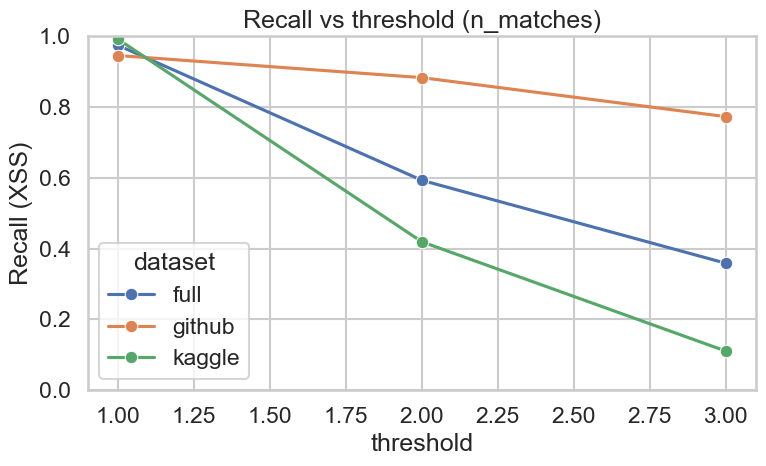

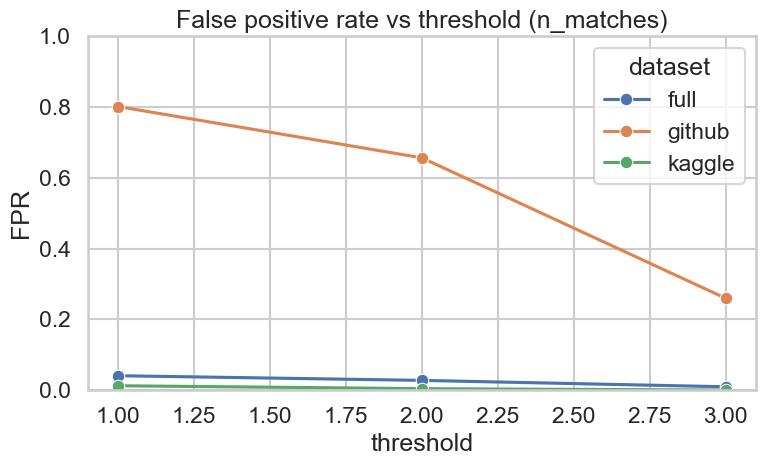

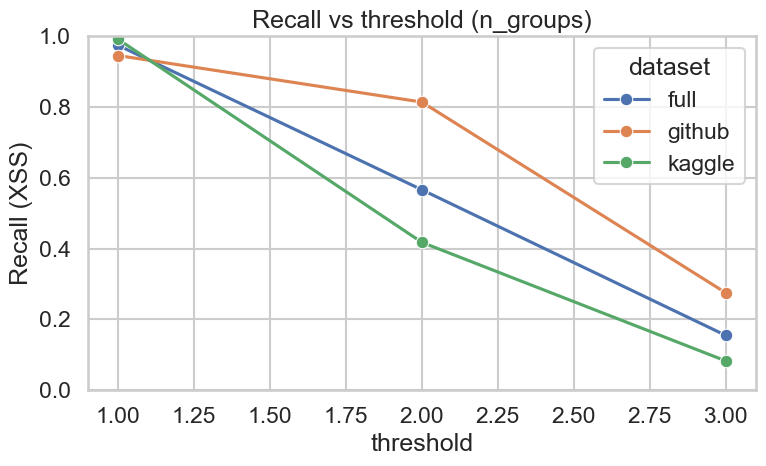

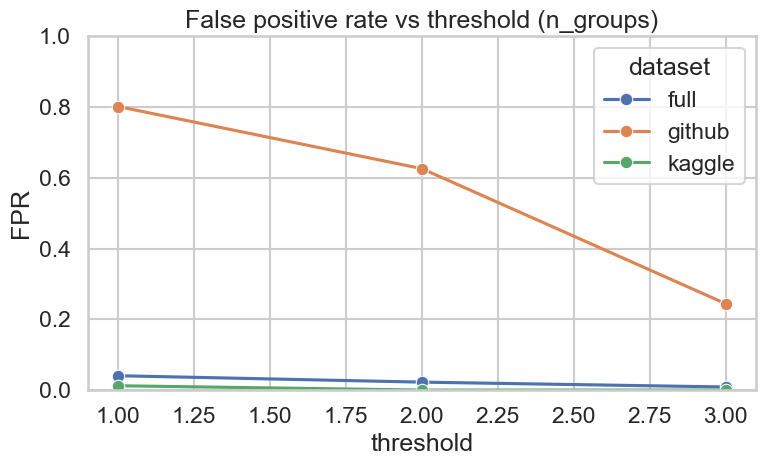

In [21]:
for score_col in ["n_matches", "n_groups"]:
    df_sub = df_tradeoff_all[df_tradeoff_all["score_type"] == score_col].copy()
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df_sub,
        x="threshold",
        y="recall_xss",
        hue="dataset",
        marker="o",
    )
    plt.title(f"Recall vs threshold ({score_col})")
    plt.ylim(0, 1)
    plt.xlabel("threshold")
    plt.ylabel("Recall (XSS)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df_sub,
        x="threshold",
        y="fpr",
        hue="dataset",
        marker="o",
    )
    plt.title(f"False positive rate vs threshold ({score_col})")
    plt.ylim(0, 1)
    plt.xlabel("threshold")
    plt.ylabel("FPR")
    plt.tight_layout()
    plt.show()

Los gráficos de *recall* y `fpr` vs umbral muestran:

- Al aumentar el umbral:
  - `fpr` baja (menos bloqueos), especialmente en GitHub.
  - `recall` baja con fuerza, sobre todo en `full` y `github`.

- En Kaggle, el punto de operación actual (umbral 1) ya ofrece un equilibrio
  excelente; subirlo apenas compensa la reducción marginal de falsos positivos
  frente a la gran pérdida de XSS detectados.

## Distribución de categorías de la API (`api_category`)

Analizamos ahora cómo se distribuyen las categorías reconocidas por la API
(`api_category`) según la etiqueta de verdad (`Label`).

In [22]:
crosstabs: Dict[str, pd.DataFrame] = {}

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    ct = pd.crosstab(df_block[LABEL_COLUMN], df_block["api_category"])
    crosstabs[dataset] = ct
    print(f"\n=== Label vs api_category — dataset={dataset} ===")
    display(ct)

for dataset, ct in crosstabs.items():
    row_norm = ct.div(ct.sum(axis=1), axis=0)
    print(f"\n=== Row-normalized Label vs api_category — dataset={dataset} ===")
    display(row_norm.round(3))


=== Label vs api_category — dataset=full ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,18,3500,4,0,24,15,1,18,6,46,16
1,906,299,25,1509,307,280,405,56,4549,63,3304



=== Label vs api_category — dataset=github ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,18,26,3,0,12,7,1,10,6,46,2
1,274,238,17,154,17,160,246,1,9,40,3229



=== Label vs api_category — dataset=kaggle ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0,3474,1,0,12,8,0,8,0,0,14
1,632,61,8,1355,290,120,159,55,4540,23,75



=== Row-normalized Label vs api_category — dataset=full ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0.005,0.959,0.001,0.000,0.007,0.004,0.000,0.005,0.002,0.013,0.004
1,0.077,0.026,0.002,0.129,0.026,0.024,0.035,0.005,0.389,0.005,0.282



=== Row-normalized Label vs api_category — dataset=github ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0.137,0.198,0.023,0.000,0.092,0.053,0.008,0.076,0.046,0.351,0.015
1,0.062,0.054,0.004,0.035,0.004,0.036,0.056,0.000,0.002,0.009,0.736



=== Row-normalized Label vs api_category — dataset=kaggle ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0.000,0.988,0.000,0.000,0.003,0.002,0.000,0.002,0.00,0.000,0.004
1,0.086,0.008,0.001,0.185,0.040,0.016,0.022,0.008,0.62,0.003,0.010


### Interpretación de `Label` vs `api_category`

Para **full**:

- Cuando `Label = 0` (benigno):
  - Un **95.9 %** cae en `api_category = benign`.
  - El resto se reparte en categorías como `scheme` (~1.3 %), `form_tag`,
    `meta_tag`, etc. Estos son los casos donde la API ve patrones sospechosos
    en tráfico etiquetado como benigno.

- Cuando `Label = 1` (XSS):
  - La categoría dominante es `neutral_polyglot`, con aproximadamente **38.9 %**.
  - `script_tag` aporta alrededor de **28.2 %** de los XSS.
  - `event`, `form_tag`, `html_like`, `image_tag` y `active_tag` completan
    el resto.

Para **github** y **kaggle** se observa un patrón similar: los XSS se concentran
en categorías como `script_tag`, `event`, `neutral_polyglot`, mientras que los
ejemplos etiquetados como benignos caen sobre todo en `benign`, con pequeños
porcentajes en categorías sospechosas.

Estas tablas resumen bien la “visión” de la API: trata de mapear cada payload
a una categoría semántica (script, evento, esquema, meta, formulario, etc.)
y a partir de eso decidir si bloquear o no.

## Longitud de los payloads por tipo de predicción

Por último, analizamos la longitud (`len_after_clean`) de los payloads según
el tipo de resultado (TP, FP, FN, TN) y el dataset.

In [23]:
length_results = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    subsets = get_error_subsets(df_block)
    for label, df_sub in subsets.items():
        tmp = df_sub[["len_after_clean"]].copy()
        tmp["dataset"] = dataset
        tmp["subset"] = label
        length_results.append(tmp)

df_length_all = pd.concat(length_results, ignore_index=True)
display(df_length_all.groupby(["dataset", "subset"])["len_after_clean"].describe())

count        mean         std   min    25%    50%     75%  \
dataset subset                                                                
full    fn        299.0  148.096990  366.001486   5.0  33.00   56.0   90.50   
        fp        148.0  100.202703  175.004294   6.0  46.00   59.5   79.50   
        tn       3500.0  248.500857  330.812833   5.0  83.00  106.0  270.00   
        tp      11404.0   76.358032  107.838677  11.0  43.00   55.0   79.00   
github  fn        238.0  173.407563  405.317677   5.0  38.25   61.5   95.75   
        fp        105.0  106.066667  186.723277   8.0  48.00   63.0   79.00   
        tn         26.0  151.538462  330.591619   8.0  18.50   26.0   86.75   
        tp       4147.0  100.315891  171.088240  12.0  43.00   62.0   95.00   
kaggle  fn         61.0   49.344262   62.839978   5.0  18.00   32.0   47.00   
        fp         43.0   85.883721  143.398248   6.0  42.00   57.0   82.00   
        tn       3474.0  249.226540  330.754869   5.0  83.25  107.0  271.75   
        tp       7257.0   62.667356   32.168723  11.0  42.00   53.0   65.00   

                   max  
dataset subset          
full    fn      2686.0  
        fp      1407.0  
        tn      2587.0  
        tp      2854.0  
github  fn      2686.0  
        fp      1407.0  
        tn      1452.0  
        tp      2854.0  
kaggle  fn       408.0  
        fp       962.0  
        tn      2587.0  
        tp       425.0

### Interpretación de la longitud de los payloads

A partir del resumen por dataset y subconjunto:

- En **full**:
  - Los **TP** (11 404 ejemplos) tienen una longitud media de **76.36** caracteres
    (mediana 55).
  - Los **FN** (299 ejemplos) tienen longitud media de **148.10** caracteres,
    casi el doble que los TP, lo que sugiere que algunos XSS largos y complejos
    son más difíciles de bloquear.
  - Los **TN** (3500 benignos correctos) tienen longitud media de **248.50**,
    más largos que los TP y FN, reflejando que mucho texto normal es extenso
    (por ejemplo, contenido HTML sin intención de ataque).

- En **github**:
  - Los FN (238 ejemplos) tienen longitud media de **173.41** caracteres.
  - Los TN son muy pocos (26) con longitud media de **151.54**, lo que hace
    más difícil extraer patrones fuertes de esta parte.

- En **kaggle**:
  - Los TP (7257 ejemplos) tienen longitud media de **62.67**.
  - Los FN (61 ejemplos) son más cortos, con media de **49.34**, lo que
    sugiere que en Kaggle los FN no se deben necesariamente a longitudes
    muy grandes, sino a características más sutiles.

En general, los payloads benignos largos tienden a no ser bloqueados (TN),
mientras que los XSS largos y complejos tienen mayor probabilidad de escapar
(ser FN), sobre todo en el dataset `full`.

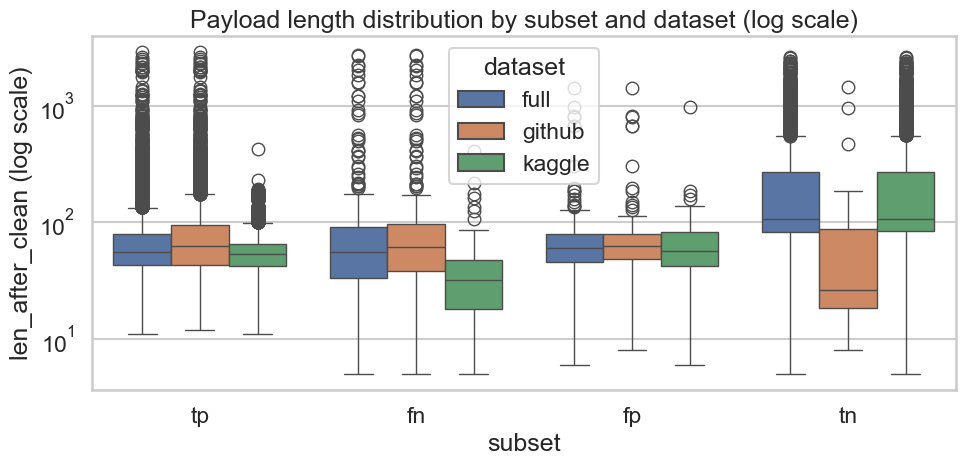

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_length_all,
    x="subset",
    y="len_after_clean",
    hue="dataset",
)
plt.yscale("log")
plt.title("Payload length distribution by subset and dataset (log scale)")
plt.xlabel("subset")
plt.ylabel("len_after_clean (log scale)")
plt.tight_layout()
plt.show()

El diagrama de cajas en escala logarítmica resume visualmente la distribución
de longitudes:

- La mayor dispersión está en los TN (texto benigno largo).
- Los TP se concentran alrededor de longitudes medias, típicas de payloads
  más compactos.
- Los FN muestran colas largas (sobre todo en `full` y `github`), indicando
  la presencia de payloads extensos que la API no bloquea.

## Análisis final de `reasons`/`matches` en falsos negativos y falsos positivos

En esta sección construimos dos “case studies”:

1. Falsos negativos de la familia `benign` (XSS que la API no bloquea).
2. Falsos positivos de GitHub (benignos que sí son bloqueados).

El objetivo es ver qué motivos (`reasons`) aparecen en el JSON de la API
y si hay patrones claros.

In [25]:
# 1) False negatives: qué patrones detecta pero no bloquea
#    (case study para la familia 'benign')

fn_rows: List[pd.DataFrame] = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    df_block["y_true"] = df_block[LABEL_COLUMN].astype(int)
    df_block["y_pred"] = df_block["api_blocked"].astype(bool).astype(int)

    # Falsos negativos: Label=1 (XSS) pero api_blocked=0
    df_fn = df_block[(df_block["y_true"] == 1) & (df_block["y_pred"] == 0)].copy()
    if df_fn.empty:
        continue

    # Extraer reasons/matches del JSON de la API
    df_fn[["reasons", "matches"]] = df_fn["api_raw_json"].apply(extract_reasons_matches)
    df_fn["dataset"] = dataset
    fn_rows.append(df_fn)

if fn_rows:
    df_fn_all = pd.concat(fn_rows, ignore_index=True)

    # Nos quedamos solo con la familia 'benign'
    df_fn_benign = df_fn_all[df_fn_all["family_main"] == "benign"].copy()

    fn_benign_case_study = (
        df_fn_benign
        .sample(min(10, len(df_fn_benign)), random_state=7)[[
            "dataset",
            "Sentence_clean",
            "family_main",
            "families_str",
            "has_script_tag",
            "has_event",
            "has_js_uri",
            "has_iframe",
            "reasons",
            "matches",
        ]]
        .reset_index(drop=True)
    )

    print("\n=== False Negative 'benign family' — Case Study (up to 10 samples) ===")
    display(fn_benign_case_study)
else:
    print("No false negatives found in BLOCK mode.")


=== False Negative 'benign family' — Case Study (up to 10 samples) ===


,dataset,Sentence_clean,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,reasons,matches
0,kaggle,document.documentURI,benign,other,False,False,False,False,[],[]
1,full,<font size=70 color=red>� audisoft+hacker+team...,benign,text_container_tag,False,False,False,False,[],[]
2,github,<img>,benign,img_tag,False,False,False,False,[],[]
3,github,<h1>rubberduck</h1><br><br><marquee>whitehat+f...,benign,marquee_tag|header_tag,False,False,False,False,[],[]
4,github,<div style=z-index:1000;width:2000px;height:20...,benign,text_container_tag,False,False,False,False,[],[]
5,full,[1].find(alert),benign,other,False,False,False,False,[],[]
6,full,"=""background-image:\\0075\\0072\\006C\\0028'\\...",benign,other,False,False,False,False,[],[]
7,github,<marquee>pappy</marquee>&missionary_id=69,benign,marquee_tag,False,False,False,False,[],[]
8,github,<marquee><h1><strong>cueballr</strong></h1></m...,benign,marquee_tag|header_tag,False,False,False,False,[],[]
9,github,<marquee><h1>defaced+by+ironzorg</h1></marquee>,benign,marquee_tag|header_tag,False,False,False,False,[],[]


En el **case study de falsos negativos de la familia `benign`**:

- Vemos payloads que el dataset marca como XSS (`Label = 1`, `family_main = benign`),
  pero la API no bloquea (`api_blocked = 0`).
- En muchos casos, las listas `reasons` y `matches` están vacías (`[]`), lo que
  indica que la API no encontró ningún patrón claro de XSS en esos payloads.

Estos ejemplos representan los XSS “más camuflados”: el sistema no encuentra
ni patrones ni estructuras típicas de XSS, por lo que, desde su lógica,
son indistinguibles de tráfico benigno.

In [26]:
# 2) GitHub false positives: benign samples que son bloqueados
#    (case study con reasons/matches)

df_github_block = dfs["github"]["block"].copy()
df_github_block["y_true"] = df_github_block[LABEL_COLUMN].astype(int)
df_github_block["y_pred"] = df_github_block["api_blocked"].astype(bool).astype(int)

# Falsos positivos: Label=0 (benigno) pero api_blocked=1
df_github_fp = df_github_block[
    (df_github_block["y_true"] == 0) & (df_github_block["y_pred"] == 1)
].copy()

df_github_fp[["reasons", "matches"]] = df_github_fp["api_raw_json"].apply(extract_reasons_matches)

github_fp_case_study = (
    df_github_fp
    .sample(min(10, len(df_github_fp)), random_state=42)[[
        "Sentence_clean",
        "family_main",
        "families_str",
        "has_script_tag",
        "has_event",
        "has_js_uri",
        "has_iframe",
        "reasons",
        "matches",
    ]]
    .reset_index(drop=True)
)

print("\n=== GitHub False Positives — Case Study (up to 10 samples) ===")
display(github_fp_case_study)


=== GitHub False Positives — Case Study (up to 10 samples) ===


,Sentence_clean,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,reasons,matches
0,<input onblur=javascript:alert(1) autofocus><i...,benign,other,False,False,False,False,"[group:event, group:form_tag, group:neutral_po...","[{'group': 'form_tag', 'pattern': '<input', 'i..."
1,<style>a{background:url('s1' 's2)}@import java...,benign,other,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
2,"<form id=""test"" /><button form=""test"" formacti...",benign,other,False,False,False,False,"[group:form_tag, group:neutral_polyglot, group...","[{'group': 'form_tag', 'pattern': '<form', 'in..."
3,"<br size=""&{javascript:alert(1)}"">",benign,other,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4,<// style=x:expression\\\\28javascript:alert(1...,benign,other,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
5,"<meta http-equiv=""link"" content=""<javascript:a...",benign,other,False,False,False,False,"[group:meta_tag, group:neutral_polyglot, group...","[{'group': 'meta_tag', 'pattern': '<meta', 'in..."
6,<embed src=javascript:alert(1)>,benign,other,False,False,False,False,"[group:active_tag, group:neutral_polyglot, gro...","[{'group': 'active_tag', 'pattern': '<embed', ..."
7,"<meta charset=""mac-farsi"">¼script¾javascript:a...",benign,other,False,False,False,False,"[group:meta_tag, group:neutral_polyglot, group...","[{'group': 'meta_tag', 'pattern': '<meta', 'in..."
8,"script>alert(""cyber_thief(turkey) hackhaber.co...",benign,other,False,False,False,False,"[group:neutral_polyglot, group:script_tag, pat...","[{'group': 'script_tag', 'pattern': '</script'..."
9,"<frame src=""javascript:alert('pappy was here')...",benign,other,False,False,False,False,"[group:active_tag, group:neutral_polyglot, gro...","[{'group': 'active_tag', 'pattern': '<frame', ..."


En el **case study de falsos positivos de GitHub**:

- Todos los ejemplos están etiquetados como benignos (`Label = 0`), pero la
  API los bloquea (`api_blocked = 1`).
- Las listas `reasons` y `matches` sí contienen información rica, por ejemplo:
  - `group:scheme`, `pattern:javascript:`
  - `group:neutral_polyglot`, `pattern:alert(`
  - `group:form_tag`, `group:meta_tag`, `group:active_tag`, `group:script_tag`, etc.

Estos falsos positivos no son “benignos triviales”: contienen estructuras que
se asemejan mucho a ataques XSS reales (esquemas JavaScript, polyglots,
meta refresh, embeds, frames, etc.). Desde el punto de vista de seguridad,
la decisión de bloquearlos es comprensible, aunque el dataset los marque
como benignos.

En conjunto, los dos case studies muestran el equilibrio que debe gestionar
la API:

- **Falsos negativos**: payloads que parecen normales y no disparan patrones.
- **Falsos positivos**: payloads anotados como benignos, pero que contienen
  estructuras típicas de XSS que la API decide no arriesgarse a dejar pasar.

# **Para el paper:**

## Figuras y tablas para el paper


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    font_scale=1.25,
    rc={
        "axes.titlesize": 18,
        "axes.labelsize": 15,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    },
)

# Paleta consistente por dataset
palette_ds = {
    "full": "#4C72B0",     # azul
    "github": "#DD8452",   # naranja
    "kaggle": "#55A868",   # verde
}


In [ ]:
# Nos quedamos solo con modo BLOCK
metrics_block = (
    df_metrics_all.reset_index()
    .query("mode == 'block'")
    .sort_values("dataset")
    .copy()
)

# Tamaño total y proporciones de clases
metrics_block["n_samples"] = (
    metrics_block["tp"] + metrics_block["fn"] +
    metrics_block["fp"] + metrics_block["tn"]
)
metrics_block["xss_ratio"] = (metrics_block["tp"] + metrics_block["fn"]) / metrics_block["n_samples"]
metrics_block["benign_ratio"] = (metrics_block["fp"] + metrics_block["tn"]) / metrics_block["n_samples"]

# === Nueva métrica: block_rate ===
metrics_block["block_rate"] = (metrics_block["tp"] + metrics_block["fp"]) / metrics_block["n_samples"]

cols_order = [
    "dataset", "n_samples",
    "tp", "fn", "fp", "tn",
    "xss_ratio", "benign_ratio",
    "block_rate",
    "recall_xss", "precision", "f1", "fpr",
]

metrics_block_paper = metrics_block[cols_order].copy()

# Redondeamos numéricos para que se vea limpio
round_cols_3 = ["xss_ratio", "benign_ratio", "block_rate"]
round_cols_4 = ["recall_xss", "precision", "f1", "fpr"]

metrics_block_paper[round_cols_3] = metrics_block_paper[round_cols_3].round(3)
metrics_block_paper[round_cols_4] = metrics_block_paper[round_cols_4].round(4)

display(metrics_block_paper)

# print(metrics_block_paper.to_latex(index=False))


,dataset,n_samples,tp,fn,fp,tn,xss_ratio,benign_ratio,block_rate,recall_xss,precision,f1,fpr
0,full,15351,11404,299,148,3500,0.762,0.238,0.753,0.9745,0.9872,0.9808,0.0406
3,github,4516,4147,238,105,26,0.971,0.029,0.942,0.9457,0.9753,0.9603,0.8015
6,kaggle,10835,7257,61,43,3474,0.675,0.325,0.674,0.9917,0.9941,0.9929,0.0122


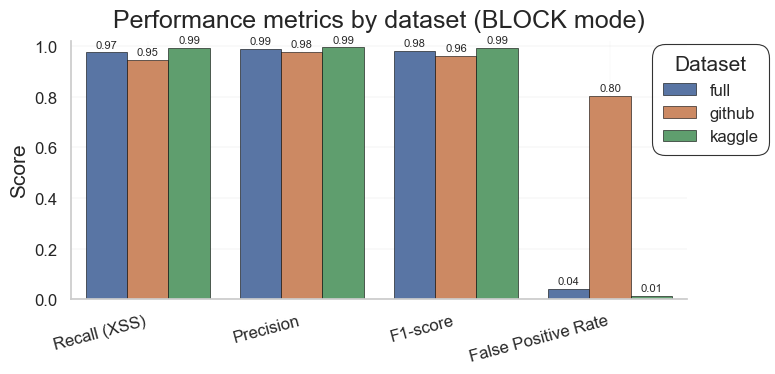

In [29]:
# ================================
# Figura — Performance metrics by dataset (BLOCK mode)
# ================================

from matplotlib.patches import FancyBboxPatch

metrics_to_plot = ["recall_xss", "precision", "f1", "fpr"]
metric_labels = {
    "recall_xss": "Recall (XSS)",
    "precision": "Precision",
    "f1": "F1-score",
    "fpr": "False Positive Rate",
}

df_plot_block = (
    df_metrics_all.reset_index()
    .query("mode == 'block'")
    .melt(
        id_vars=["dataset"],
        value_vars=metrics_to_plot,
        var_name="metric",
        value_name="score",
    )
    .replace({"metric": metric_labels})
)

metric_order = ["Recall (XSS)", "Precision", "F1-score", "False Positive Rate"]

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=df_plot_block,
    x="metric",
    y="score",
    hue="dataset",
    hue_order=sorted(df_plot_block["dataset"].unique()),
    order=metric_order,
    palette=palette_ds,
    edgecolor="black",
    linewidth=0.4,
)

# Suavizar líneas horizontales de la grilla
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, alpha=0.5)
ax.xaxis.grid(True, which="major", linestyle="-", linewidth=0.3, alpha=0.25)  

ax.set_ylim(0, 1.02)
ax.set_xlabel("")
ax.set_ylabel("Score")
ax.set_title("Performance metrics by dataset (BLOCK mode)", pad=10)

# Etiquetas numéricas
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=8, padding=2)

plt.xticks(rotation=15, ha="right")

# --- Leyenda con borde suave y esquinas redondeadas ---
legend = plt.legend(
    title="Dataset",
    bbox_to_anchor=(0.95, 0.97),
    loc="upper left",
    borderaxespad=0,
    frameon=True,
)

# Reemplazar el frame por un FancyBboxPatch redondeado
frame = legend.get_frame()
frame.set_linewidth(0.8)
frame.set_edgecolor("black")
frame.set_facecolor("white")
frame.set_boxstyle("round,pad=0.25,rounding_size=0.8") 

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# TABLA — RENDIMIENTO POR FAMILIA Y DATASET (MODO BLOCK)
# ============================================

# Partimos de df_family_all ya construido antes
# Columnas esperadas: ["family_main","n","tp","fn","fp","tn","recall_xss","fpr","dataset"]

df_family_paper = (
    df_family_all.copy()
    # (opcional) filtrar familias muy raras; aquí dejamos todas las que ya tienes
    # .query("n >= 50")
    .sort_values(["dataset", "family_main"])
)

# Precision por familia (cuidando divisiones por cero)
df_family_paper["precision"] = df_family_paper.apply(
    lambda r: r["tp"] / (r["tp"] + r["fp"]) if (r["tp"] + r["fp"]) > 0 else 0.0,
    axis=1,
)

# Reordenamos y redondeamos
cols_order = [
    "dataset", "family_main", "n",
    "tp", "fn", "fp", "tn",
    "recall_xss", "precision", "fpr",
]

df_family_paper = df_family_paper[cols_order].copy()

df_family_paper[["recall_xss", "precision", "fpr"]] = (
    df_family_paper[["recall_xss", "precision", "fpr"]].round(4)
)

display(df_family_paper)

# print(df_family_paper.to_latex(index=False, float_format="%.4f"))



,dataset,family_main,n,tp,fn,fp,tn,recall_xss,precision,fpr
1,full,benign,4030,134,270,128,3498,0.3317,0.5115,0.0353
0,full,event,7667,7630,29,6,2,0.9962,0.9992,0.7500
3,full,iframe,210,210,0,0,0,1.0000,1.0000,0.0000
4,full,js_uri,36,36,0,0,0,1.0000,1.0000,0.0000
2,full,script,3408,3394,0,14,0,1.0000,0.9959,1.0000
7,github,benign,439,99,209,105,26,0.3214,0.4853,0.8015
6,github,event,561,532,29,0,0,0.9483,1.0000,0.0000
8,github,iframe,207,207,0,0,0,1.0000,1.0000,0.0000
5,github,script,3309,3309,0,0,0,1.0000,1.0000,0.0000
10,kaggle,benign,3591,35,61,23,3472,0.3646,0.6034,0.0066


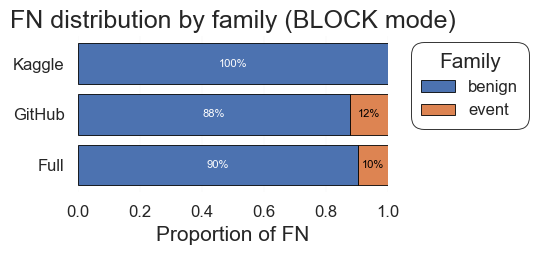

In [31]:
# ============================================
# Figura 2 — Proportion of FN by family (BLOCK)
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns

# -------------------------------------------------
# 1) Construir proporciones de FN por familia/dataset
# -------------------------------------------------

# df_fn_all debe contener SOLO los falsos negativos en modo BLOCK,
# con columnas: dataset, family_main (y lo que quieras adicional).

# 1.1 Contar FNs por (dataset, family_main)
df_counts = (
    df_fn_all
    .groupby(["dataset", "family_main"])
    .size()
    .reset_index(name="n_fn")
)

# 1.2 Totales de FN por dataset
df_totals = (
    df_counts
    .groupby("dataset")["n_fn"]
    .sum()
    .reset_index(name="total_fn")
)

# 1.3 Merge y cálculo de proporciones
df_fn_prop = df_counts.merge(df_totals, on="dataset", how="left")
df_fn_prop["prop_fn"] = df_fn_prop["n_fn"] / df_fn_prop["total_fn"]

# 1.4 Etiquetas amigables
dataset_labels = {"full": "Full", "github": "GitHub", "kaggle": "Kaggle"}
df_fn_prop["Dataset"] = df_fn_prop["dataset"].map(dataset_labels)
df_fn_prop["Family"] = df_fn_prop["family_main"]

# -------------------------------------------------
# 2) Orden y colores (solo familias de interés)
# -------------------------------------------------

order_dataset = ["Full", "GitHub", "Kaggle"]
order_family = ["benign", "event"]
family_colors = {"benign": "#4C72B0", "event": "#DD8452"}

# Pivot para stacked bar horizontal
table = (
    df_fn_prop
    .pivot(index="Dataset", columns="Family", values="prop_fn")
    .reindex(order_dataset)
)

# Nos quedamos solo con las columnas que existan realmente
cols_present = [fam for fam in order_family if fam in table.columns]
table = table[cols_present].fillna(0.0)

# -------------------------------------------------
# 3) Figura (formato compatible con 1 columna IEEE)
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(5.2, 2.8))  # ≈ ancho de una columna IEEE

bottom = np.zeros(len(table))

for fam in cols_present:
    vals = table[fam].values
    ax.barh(
        table.index,
        vals,
        left=bottom,
        color=family_colors.get(fam, "#999999"),
        edgecolor="black",
        linewidth=0.6,
        label=fam,
    )

    # Porcentajes centrados en el segmento
    for i, v in enumerate(vals):
        if v > 0.02:  # solo etiquetamos si el segmento es > 2%
            ax.text(
                bottom[i] + v / 2,
                i,
                f"{v*100:.0f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="white" if v > 0.25 else "black",
            )

    bottom += vals

# -------------------------------------------------
# 4) Estética y leyenda
# -------------------------------------------------

ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of FN")
ax.set_ylabel("")
ax.set_title("FN distribution by family (BLOCK mode)", pad=6)

# Líneas verticales suaves
ax.xaxis.grid(True, linestyle="-", linewidth=0.3, alpha=0.25)
ax.yaxis.grid(False)

# Leyenda fuera del gráfico, con borde suave
legend = fig.legend(
    title="Family",
    loc="center left",
    bbox_to_anchor=(0.8, 0.65),
    frameon=True,
)

frame = legend.get_frame()
frame.set_linewidth(0.7)
frame.set_edgecolor("black")
frame.set_facecolor("white")

# En algunos backends, el frame ya es FancyBboxPatch y soporta boxstyle;
# si no, esta línea se puede comentar si diera problemas.
if isinstance(frame, FancyBboxPatch):
    frame.set_boxstyle("round,pad=0.25,rounding_size=0.8")

sns.despine(left=True, bottom=True)

# Dejar espacio a la derecha para la leyenda
plt.tight_layout(rect=(0, 0, 0.83, 1))
plt.show()


In [32]:
# === Tabla final completa de longitudes de payload ===
# Orden lógico
subset_order = ["tp", "fn", "fp", "tn"]
dataset_order = ["full", "github", "kaggle"]

# Construcción de tabla con estadísticas completas
length_summary = (
    df_length_all
    .groupby(["dataset", "subset"])
    .agg(
        count=("len_after_clean", "count"),
        mean=("len_after_clean", "mean"),
        median=("len_after_clean", "median"),
        std=("len_after_clean", "std"),
        p25=("len_after_clean", lambda x: x.quantile(0.25)),
        p75=("len_after_clean", lambda x: x.quantile(0.75)),
        min_val=("len_after_clean", "min"),
        max_val=("len_after_clean", "max"),
    )
    .reset_index()
)

# Orden
length_summary["dataset"] = pd.Categorical(length_summary["dataset"], categories=dataset_order, ordered=True)
length_summary["subset"] = pd.Categorical(length_summary["subset"], categories=subset_order, ordered=True)

length_summary = length_summary.sort_values(["dataset", "subset"])

# Redondeo
length_summary = length_summary.round({
    "mean": 2,
    "median": 2,
    "std": 2,
    "p25": 2,
    "p75": 2,
    "min_val": 2,
    "max_val": 2,
})

display(length_summary)

# LaTeX opcional (lista para IEEE)
# print(length_summary.to_latex(index=False, float_format="%.2f"))


,dataset,subset,count,mean,median,std,p25,p75,min_val,max_val
3,full,tp,11404,76.36,55.0,107.84,43.00,79.00,11,2854
0,full,fn,299,148.10,56.0,366.00,33.00,90.50,5,2686
1,full,fp,148,100.20,59.5,175.00,46.00,79.50,6,1407
2,full,tn,3500,248.50,106.0,330.81,83.00,270.00,5,2587
7,github,tp,4147,100.32,62.0,171.09,43.00,95.00,12,2854
4,github,fn,238,173.41,61.5,405.32,38.25,95.75,5,2686
5,github,fp,105,106.07,63.0,186.72,48.00,79.00,8,1407
6,github,tn,26,151.54,26.0,330.59,18.50,86.75,8,1452
11,kaggle,tp,7257,62.67,53.0,32.17,42.00,65.00,11,425
8,kaggle,fn,61,49.34,32.0,62.84,18.00,47.00,5,408


In [33]:
# Tres falsos negativos de familia 'benign'
fn_small = df_fn_benign.sample(min(3, len(df_fn_benign)), random_state=1)[
    ["dataset", "Sentence_clean", "api_category", "reasons"]
].copy()
fn_small["type"] = "FN"

# Tres falsos positivos de GitHub
fp_small = df_github_fp.sample(min(3, len(df_github_fp)), random_state=1)[
    ["Sentence_clean", "api_category", "reasons"]
].copy()
fp_small["dataset"] = "github"
fp_small["type"] = "FP"

case_study = pd.concat([fn_small, fp_small], ignore_index=True)

max_len_snippet = 80
case_study["Sentence_snippet"] = case_study["Sentence_clean"].str.slice(0, max_len_snippet) + "..."

case_study_paper = case_study[[
    "type", "dataset", "api_category", "Sentence_snippet", "reasons"
]].copy()

display(case_study_paper)

# LaTeX opcional:
# print(case_study_paper.to_latex(index=False))


,type,dataset,api_category,Sentence_snippet,reasons
0,FN,full,benign,<marquee>testicles was here</marquee>...,[]
1,FN,github,benign,<marquee><h1>defaced+by+www.r3t.n3t.nl</h1></m...,[]
2,FN,github,benign,<h1>rubberduck</h1><br><br><marquee>whitehat f...,[]
3,FP,github,scheme,<style>a{background:url('s1' 's2)}@import java...,"[group:neutral_polyglot, group:scheme, pattern..."
4,FP,github,active_tag,"<math href=""javascript:javascript:alert(1)"">cl...","[group:active_tag, group:image_tag, group:neut..."
5,FP,github,scheme,<style>p[foo=bar{}*{-o-link:'javascript:javasc...,"[group:neutral_polyglot, group:scheme, pattern..."


In [ ]:
# Subconjunto: sólo GitHub y score_type = 'n_matches'
df_tradeoff_github_nm = (
    df_tradeoff_all
    .query("dataset == 'github' and score_type == 'n_matches'")
    .copy()
)

# Nos quedamos con las columnas clave y renombramos para el paper
tradeoff_table_github = (
    df_tradeoff_github_nm[["threshold", "recall_xss", "fpr", "precision", "f1"]]
    .rename(columns={
        "threshold": "threshold",
        "recall_xss": "recall_xss",
        "fpr": "fpr",
        "precision": "precision",
        "f1": "f1",
    })
)

display(tradeoff_table_github)

# print(tradeoff_table_github.to_latex(index=False, float_format="%.4f"))


,threshold,recall_xss,fpr,precision,f1
6,1,0.945724,0.801527,0.975306,0.960287
7,2,0.883238,0.656489,0.978277,0.928332
8,3,0.773090,0.259542,0.990070,0.868229


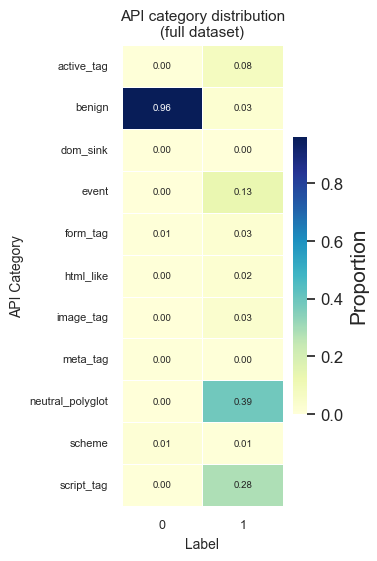

In [37]:
# Partimos del crosstab ya calculado
ct_full = crosstabs["full"].copy()

# Normalización por fila
row_norm_full = ct_full.div(ct_full.sum(axis=1), axis=0)

# Reordenamos para heatmap: categorías como filas, Label como columnas
heatmap_data = row_norm_full.T

plt.figure(figsize=(4, 6))  # <-- tamaño ideal para UNA columna IEEE
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.4,
    cbar_kws={
        "label": "Proportion",
        "shrink": 0.6,   # cbar más compacto
    },
    annot_kws={"size": 7},  # anotaciones más pequeñas
)

plt.title(
    "API category distribution\n(full dataset)", 
    fontsize=11, 
    pad=6
)
plt.xlabel("Label", fontsize=10)
plt.ylabel("API Category", fontsize=10)

plt.xticks(rotation=0, fontsize=9)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout(pad=1.4)
plt.show()


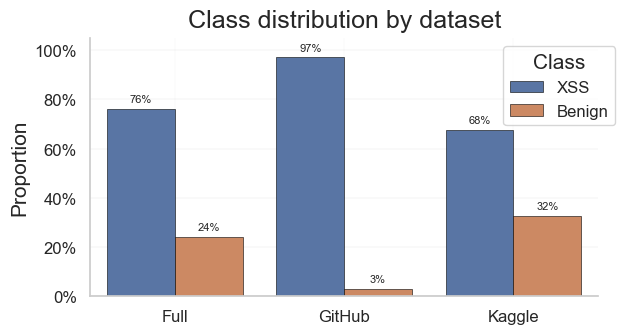

In [36]:
from matplotlib.ticker import FuncFormatter

# --- Data long con proporciones correctas ---
df_class = metrics_block_paper[["dataset", "xss_ratio", "benign_ratio"]].copy()

df_class_long = (
    df_class
    .melt(
        id_vars="dataset",
        value_vars=["xss_ratio", "benign_ratio"],
        var_name="Class",
        value_name="prop",
    )
    .replace(
        {
            "dataset": {"full": "Full", "github": "GitHub", "kaggle": "Kaggle"},
            "Class": {"xss_ratio": "XSS", "benign_ratio": "Benign"},
        }
    )
)

plt.figure(figsize=(6.5, 3.6))
ax = sns.barplot(
    data=df_class_long,
    x="dataset",
    y="prop",
    hue="Class",
    hue_order=["XSS", "Benign"],
    palette=["#4C72B0", "#DD8452"],
    edgecolor="black",
    linewidth=0.4,
)
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, alpha=0.5)
ax.xaxis.grid(True, which="major", linestyle="-", linewidth=0.3, alpha=0.25)  

ax.set_xlabel("")
ax.set_ylabel("Proportion")
ax.set_title("Class distribution by dataset", pad=8)
ax.set_ylim(0, 1.05)

# Formato de eje Y como porcentaje
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))

# Etiquetas de porcentaje sobre cada barra
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height*100:.0f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.legend(title="Class", loc="upper right", bbox_to_anchor=(1.05, 1.0), frameon=True)
sns.despine()
plt.tight_layout()
plt.show()

